# Projet MOGPL: la balade du robot

### Sportich Benjamin, de Bézenac Emmanuel

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## GENERATION ALEATOIRE D'INSTANCES

## LECTURE ET ECRITURE DE FICHIER

In [2]:
def read_entry_file(filename):
    with open(filename) as f:
        M,N = [int(x) for x in f.readline().split()] # lecture de la premiere ligne
        array = []
        i=0
        for line in f: 
            if(i<int(M)): # lecture du bloc
                array.append(np.array([int(x) for x in line.split()]))
                i+=1
            else: #lecture du début, de la fin, ainsi que de la direction
                iStart,jStart,iEnd,jEnd=[int(line.split()[i]) for i in range(4)]
                startDir=line.split()[4]
                if(startDir=='nord'):
                    startDir=1
                if(startDir=='est'):
                    startDir=2
                if(startDir=='sud'):
                    startDir=3
                if(startDir=='ouest'):
                    startDir=4 
                break
    return M,N,np.array(array),(iStart,jStart,startDir),(iEnd,jEnd,1)

def write_entry_file(filename,A,startPos,endPos,startDir):
    f=open(filename,'w')
    f.write(str(A.shape[0])+' '+str(A.shape[1])+'\n')
    for i in A:
        f.write(' '.join(str(int(e)) for e in i))
        f.write('\n')
    if(startDir==1):
        d='nord'
    if(startDir==2):
        d='est'
    if(startDir==3):
        d='sud'
    if(startDir==4):
        d='ouest'
    f.write(str(startPos[0])+' '+str(startPos[1])+' '+str(endPos[0])+' '+str(endPos[1])+' '+d+'\n')
    f.write('0 0\n')
    f.close()

def write_result_file(filename,mod,result):
    f=open(filename,mod)
    f.write(str(result[0])+' '+' '.join(e for e in result[1])+'\n')
    f.close()

Exemple:

In [3]:
m,n,A,st,fi=read_entry_file('entree.txt')
print m,n,A,st,fi

9 10 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]] (7, 2, 3) (2, 7, 1)


In [4]:
def is_obstacle(i,j,A):
    M=A.shape[0]
    N=A.shape[1]
    #Cas Limites
    if(i==0): #Premiere ligne
        if(j==0): #Premiere case
            return A[0][0]
        if(j==N): #Derniere case
            return A[0][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[0][j] or A[0][j-1]       
    if(i==M): #Dernière ligne
        if(j==0): #Premiere case
            return A[M-1][0]
        if(j==N): #Derniere case
            return A[M-1][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[M-1][j-1] or A[M-1][j] 
    if(j==0): #Premiere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i][0] or A[i-1][0]       
    if(j==N): #Derniere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i-1][N-1] or A[i][N-1] 
    #Cas General
    if( i>=1 and j>=1 and i<M and j<N and A[i-1][j-1]==0 and A[i][j-1]==0 and A[i-1][j]==0 ):
        return A[i][j]
    return 1 

## CREATION & GESTION DU GRAPHE

### Génère le graphe en fonction du tableau d'obstacles

In [5]:
def gen_graph(A):
    M=A.shape[0]
    N=A.shape[1]
    G=nx.DiGraph()
    for i in range(M+1):
        for j in range(N+1):
            if(is_obstacle(i,j,A)==False):              
                #Creation des noeuds - un par direction = 4 par position                
                G.add_node((i,j,1),direct='nord')
                G.add_node((i,j,2),direct='est')
                G.add_node((i,j,3),direct='sud')
                G.add_node((i,j,4),direct='ouest')

                #Creation des arcs
                #Changement des directions               
                G.add_edge((i,j,1),(i,j,2),action='D')
                G.add_edge((i,j,1),(i,j,4),action='G')
                G.add_edge((i,j,2),(i,j,3),action='D')
                G.add_edge((i,j,3),(i,j,4),action='D')

                G.add_edge((i,j,2),(i,j,1),action='G')
                G.add_edge((i,j,4),(i,j,1),action='D')
                G.add_edge((i,j,3),(i,j,2),action='G')
                G.add_edge((i,j,4),(i,j,3),action='G')

                #Deplacement
                #Nord/Haut
                for k in [1,2,3]:
                    if(is_obstacle(i-k,j,A)==False):
                        G.add_edge((i,j,1),(i-k,j,1),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                #Est/Droite
                for k in [1,2,3]:
                    if(is_obstacle(i,j+k,A)==False):
                        G.add_edge((i,j,2),(i,j+k,2),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j+k on ne creer pas d'arc en j+k+1
                
                #Sud/Bas
                for k in [1,2,3]:
                    if(is_obstacle(i+k,j,A)==False):
                        G.add_edge((i,j,3),(i+k,j,3),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i+k on ne creer pas d'arc en i-k+1
                
                #Ouest/Gauche
                for k in [1,2,3]:
                    if(is_obstacle(i,j-k,A)==False):
                        G.add_edge((i,j,4),(i,j-k,4),action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en j-k on ne creer pas d'arc en j-k-1
                        
    return G

## GENERATION ALEATOIRE D'INSTANCE

In [6]:
def gen_rand_instance(M,N,nb_obstacles):
    A=np.zeros((M,N),dtype=int)
    obstacles=[]
    if(nb_obstacles<=M*N-4):
        #Generation d'obstacles
        for i in range(nb_obstacles):
            obstacle=(int(np.random.rand()*M),int(np.random.rand()*N))
            while(obstacle in obstacles): #Obstacle déjà créé
                obstacle=(int(np.random.rand()*M),int(np.random.rand()*N))
            A[obstacle]=1
            obstacles.append(obstacle)        
    else:
        print 'Erreur, trop d\'obstacles.'
        
    return A

def gen_rand_positions(G):
    startPos=np.random.choice(G.nodes())
    endPos=np.random.choice(G.nodes())
    return startPos,endPos

Exemple:

In [7]:
print gen_rand_instance(5,5,16)

[[0 0 1 1 1]
 [0 1 1 0 1]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 1 1 0 1]]


## MEILLEUR CHEMIN

In [8]:
def BFS(start,end,G):
    dist={}
    for i in G.nodes():
        dist[i]=[np.inf,None] #dist: [distance a start, predecessor]
    dist[start][0]=0
    q=[start]
    while(q):
        u=q.pop(0)
        for v in G.neighbors(u):
            if(np.isinf(dist[v][0])):
                dist[v][0]=dist[u][0]+1
                dist[v][1]=u
                q.append(v)
                #if(v[:-1]==end[:-1]): #on s'arrete lorsqu'on voit la fin
                #    return dist
    return dist

def gen_shortest_path(start,end,G):
    #Backtracking: on retrouve le chemin minimal a partir d'un des 4 sommets de la fin
    dist=BFS(start,end,G)
    path=[]
    path_edges=[]
    prec=end
    while(prec!=start):
        temp=prec
        if(dist[prec][1]is None):
            return -1,[],[]
        else:
            prec=dist[prec][1]
        #Si on est deja sur un des 4 sommets de la case de finale on n'ajoute rien au chemin
        if(prec[0:2]!=end[0:2] or temp[0:2]!=end[0:2]):
            path_edges.append([prec,temp])
            path.append(G[prec][temp]['action'])
    return len(path),path[::-1],path_edges[::-1]

## INTERFACE

In [9]:
from matplotlib.table import Table
import matplotlib.lines as lines
from matplotlib.patches import Circle, Arrow,FancyArrowPatch

def show_interface(result,A,startPos,endPos):
    colors=['white','grey']
    fig=plt.figure(figsize=(10,10))
    ax=plt.subplot(111)    
    ax.set_ylim([0,A.shape[0]])
    ax.set_xlim([0,A.shape[1]])
    ax.set_axis_off()
    tb = Table(ax, bbox=[0,0,1,1])
    nrows, ncols = A.shape
    width, height = 1.0 / ncols, 1.0 / nrows
    # Add cells
    for (i,j),val in np.ndenumerate(A):
        color=colors[val]
        tb.add_cell(i, j, width, height,loc='center', facecolor=color)
    # Row Labels...
    for i in range(A.shape[0]):
        tb.add_cell(i, -1, width, height, text=i, loc='right', 
                    edgecolor='none', facecolor='none')
    # Column Labels
    for j in range(A.shape[1]):
        tb.add_cell(-1, j, width, height/2, text=j, loc='center', 
                           edgecolor='none', facecolor='none')
    ax.add_table(tb)
    
    #Ajout Chemin
    for i,j in result[2]:
        ax.add_line(lines.Line2D((i[1],j[1]),(i[0],j[0]),linewidth=3,zorder=1))
    
    #Ajout Depart
    start=startPos[:2][::-1]
    start_circle=Circle(start,radius=0.2,alpha=0.8, color='g',zorder=2,label='Position de Depart')
    ax.add_patch(start_circle)
    
    #Ajout Direction de Depart
    start_dir=startPos[2]
    start_posA=start
    if(start_dir==1):        
        start_posB=(start_posA[0],start_posA[1]-1)
    if(start_dir==2):
        start_posB=(start_posA[0]+1,start_posA[1])
    if(start_dir==3):
        start_posB=(start_posA[0],start_posA[1]+1)
    if(start_dir==4):
        start_posB=(start_posA[0]-1,start_posA[1])    
    arrow=FancyArrowPatch(start_posA,start_posB,arrowstyle='->',color='m',mutation_scale=15.0,lw=2,zorder=3,label='Sens de Depart')
    ax.add_patch(arrow)

    #Ajout Arrivee
    end=endPos[:2][::-1]
    end_circle=Circle(end,radius=0.2,alpha=0.9, color='r',zorder=2,label='Position d\'arrivee')
    ax.add_patch(end_circle)
    
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

## MAIN

### Avec instance decrite dans le projet

(12, ['D', 'a1', 'D', 'a3', 'a3', 'D', 'a1', 'a3', 'D', 'a1', 'G', 'a2'])


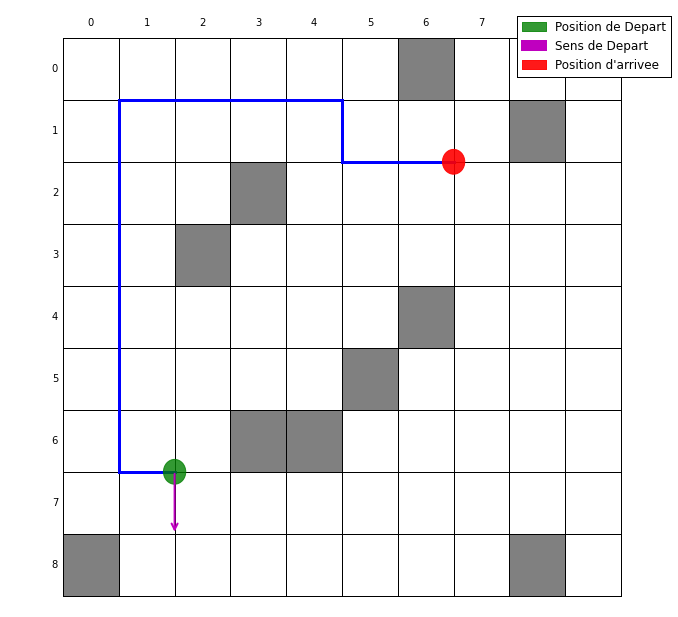

In [10]:
m,n,A,start,end=read_entry_file('entree.txt')  
G=gen_graph(A)
result=gen_shortest_path(start,end,G)
print result[:-1]
f=show_interface(result,A,start,end)
write_result_file('resultat.txt','w',result[:2])

### Avec instance aléatoire

(56, ['a3', 'G', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'G', 'a3', 'D', 'a3', 'a3', 'G', 'a3', 'D', 'a2', 'G', 'a3', 'D', 'a2', 'a3', 'G', 'a3', 'a3', 'a3', 'G', 'a3', 'a2', 'a2', 'D', 'a3', 'a3', 'G', 'a3', 'a3', 'a3', 'D', 'a1', 'a3', 'a3', 'a3', 'a3', 'G', 'a3', 'D', 'a3', 'G', 'a3', 'D', 'a2', 'a3', 'a3', 'a2', 'G', 'a2'])


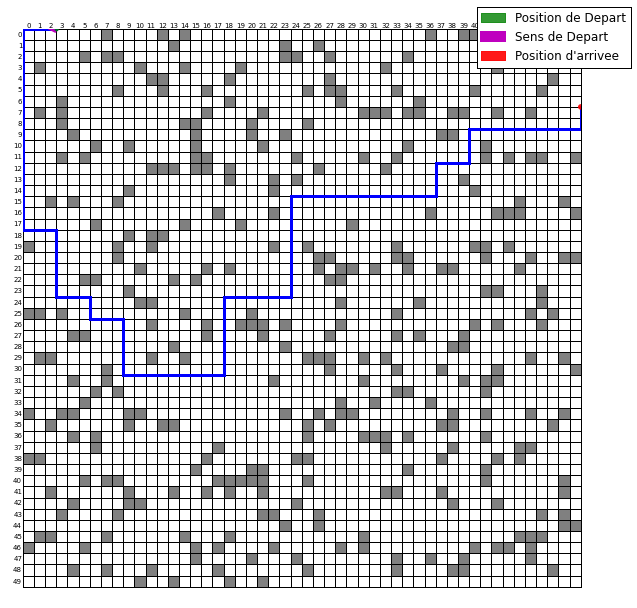

In [56]:
A2=gen_rand_instance(50,50,350)
G2=gen_graph(A2)
start2,end2=gen_rand_positions(G2)
result2=gen_shortest_path(start2,end2,G2)
print result2[:-1]
show_interface(result2,A2,start2,end2)
write_result_file('rand_resultat.txt','w',result2[:-1])

Taille? (X*X) 100

Nombre d'obstacles? 0

Total time: 2.42759299278

Gen Instance:0.000394105911255

Gen Graph:1.7458178997

Gen Rand Pos:0.0134749412537

Gen shortest path:0.667906045914

(15, ['D', 'a2', 'a3', 'a3', 'a2', 'a3', 'D', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3'])


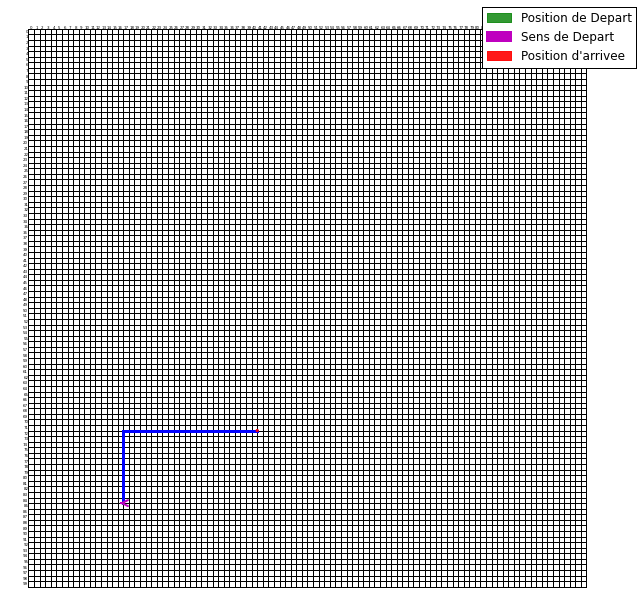

In [34]:
import time
M=int(raw_input('Taille? (X*X) '))
nb_obstacles=int(raw_input('\nNombre d\'obstacles? '))
t0=time.time()
A3=gen_rand_instance(M,M,nb_obstacles)
t1=time.time()
G3=gen_graph(A3)
t2=time.time()
start3,end3=gen_rand_positions(G3)
t3=time.time()
result3=gen_shortest_path(start3,end3,G3)
tf=time.time()
print '\nTotal time: '+str(tf-t0)
print '\nGen Instance:'+str(t1-t0)
print '\nGen Graph:'+str(t2-t1)
print '\nGen Rand Pos:'+str(t3-t2)
print '\nGen shortest path:'+str(tf-t3)+'\n'
print result3[:-1]
show_interface(result3,A3,start3,end3)
#write_result_file('rand_resultat.txt','w',result3[:-1])

## AFFICHAGE DU GRAPHE

In [23]:
from matplotlib.patches import FancyArrowPatch, Circle

def fixed_pos(G): #Assigne des positions aux noeuds du graphe
    fixed_pos={}
    for n in G.nodes():
        if(n[2]==1):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4)
        if(n[2]==2):
            fixed_pos[n]=(int(n[1])*4+2,int(n[0])*4+1)
        if(n[2]==3):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4+2)
        if(n[2]==4):
            fixed_pos[n]=(int(n[1])*4,int(n[0])*4+1)        
    return fixed_pos


def draw_graph(G,pos,ax,sg=None): #Genere l'affichage du graphe
    G_new=G.copy()
    for n in G_new:
        c=Circle(pos[n],radius=0.15,alpha=0.5)
        ax.add_patch(c)
        G_new.node[n]['patch']=c
        x,y=pos[n]
    seen={}
    for (u,v,d) in G_new.edges(data=True):
        n1=G_new.node[u]['patch']
        n2=G_new.node[v]['patch']
        rad=0.2
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            alpha=alpha,
                            color=color)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e

def show_graph(G): # affiche le graphe
    fig=plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    ax.invert_yaxis()
    draw_graph(G,fixed_pos(G),ax)
    ax.autoscale()
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('graph2.png')
    plt.show()
    #nx.draw_networkx(G,fixed_pos,ax=axe,arrows=True,node_size=400,font_size=10)
    #nx.draw(G,fixed_pos(G),ax=axe)

Exemple:

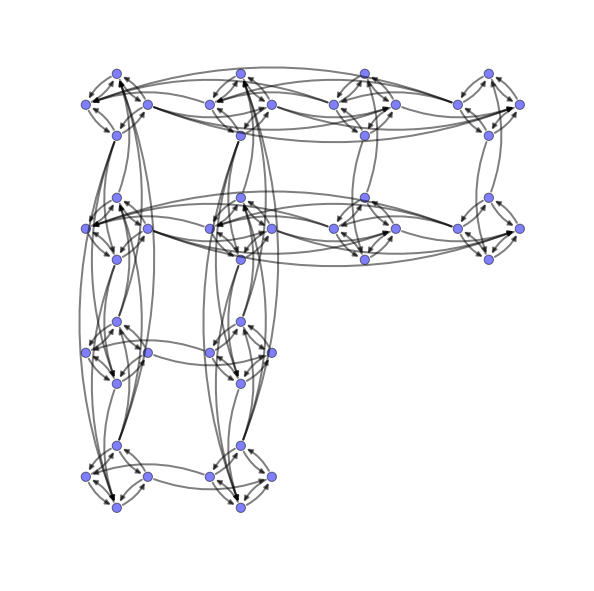

In [24]:
m,n,A,start,end=read_entry_file('entree.txt')
G=gen_graph(A[0:3,1:4]) #A original trop grand pour pouvoir l'afficher en entier
show_graph(G)


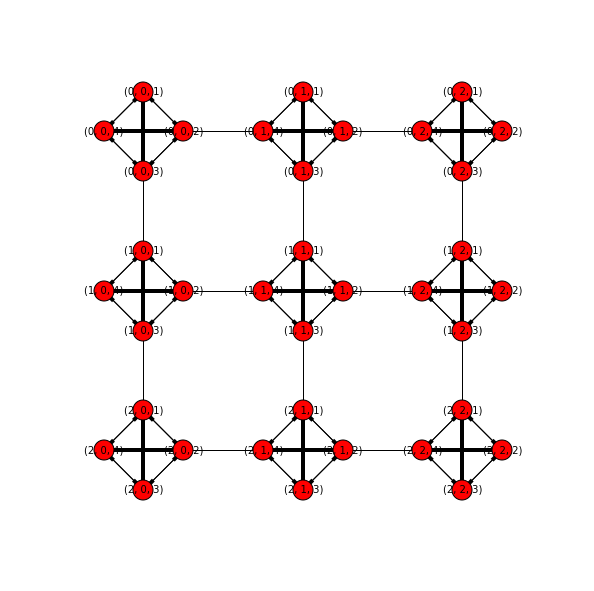

In [66]:
M2,N2=2,2
A=np.zeros((M2,N2))
G2=gen_graph(A)
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(111)
ax.invert_yaxis()
ax.autoscale()
nx.draw_networkx(G2,fixed_pos(G2),ax=ax,arrows=True,node_size=400,font_size=10)
#nx.draw(G,fixed_pos(G),ax=ax)
plt.axis('equal')
plt.axis('off')
plt.show()